In [59]:
import pandas as pd
import numpy as np
from directory import data as data_dir, images
import scipy.stats as sstats
import statsmodels.stats.weightstats as wstats

In [35]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn-ticks')
palette = sns.color_palette(palette='deep').as_hex()
%matplotlib inline
pd.options.display.max_columns=100

from clustering import drop_columns

plt.rcParams['font.size'] = 16
sns.set_context(rc = {'patch.linewidth': 0.0})

import paxplot
from importlib import reload
reload(paxplot)
from paxplot import centroid_plot, cluster_plots, pca_2comp_plot, generate_feature_labels

In [8]:
drop_cols = ['age_median2017', 'population_total2017', 'household_income_median2017',\
    'home_value_median2017', 'housing_units_total2017', 'geoid', 'oz', \
    'LICadj', 'eligible']

In [9]:
def generate_feature_labels(columns):
    new_columns = []
    for c in columns:
        c = c.rstrip("2017").replace("total", "").replace("median", "")
        c = c.replace("change", u"Δ").replace("percent", "%").replace("_", " ")
        c = c.replace("tenure", "").replace("occupancy", "").replace("race", "")
        new_columns.append(c)
    return new_columns
generate_feature_labels(drop_cols)

['age ',
 'population ',
 'household income ',
 'home value ',
 'housing units ',
 'geoid',
 'oz',
 'LICadj',
 'eligible']

In [10]:
labels = pd.read_pickle("{}/kmeanslabels.pkl".format(data_dir))
clean = pd.read_pickle("{}/clean.pkl".format(data_dir))
ozs = clean[clean['oz'] == 1].reset_index(drop=True)
all_e = clean[clean['eligible'] == 1]
not_picked = all_e[all_e['oz'] == 0]

In [100]:
!open ../images/kmeans/k=6.png

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [16]:
data_labels = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'other eligible tracts']
X_e = not_picked.drop(columns=drop_cols)
X_ozs = ozs.drop(columns=drop_cols)
features= X_e.columns
feature_labels = generate_feature_labels(features)

In [17]:
k6 = labels[['k=6', 'k6silhouette_score']]
outliers_mask = k6['k6silhouette_score'] < 0
outliers = ozs[outliers_mask]
cluster_masks = []

for c in np.unique(k6['k=6']):
    cluster_masks.append(k6['k=6'] == c)

In [18]:
X_alle = all_e.drop(columns=drop_cols)
std_scaler = StandardScaler()
std_X = std_scaler.fit_transform(X_alle)
n = 9
paxPCA = PCA(n_components=n)
pca_all = paxPCA.fit(std_X)

In [19]:
pca_objs = []
data = [X_e, X_ozs]
for d in data:  
    std_scaler = StandardScaler()
    std_X = std_scaler.fit_transform(d)
    n = 9
    paxPCA = PCA(n_components=n)
    pca_objs.append(paxPCA.fit(std_X))

In [20]:
suspect = pd.read_pickle("{}/suspect_tracts.pkl".format(data_dir))
suspect_dropped = drop_columns(suspect, drop_cols)

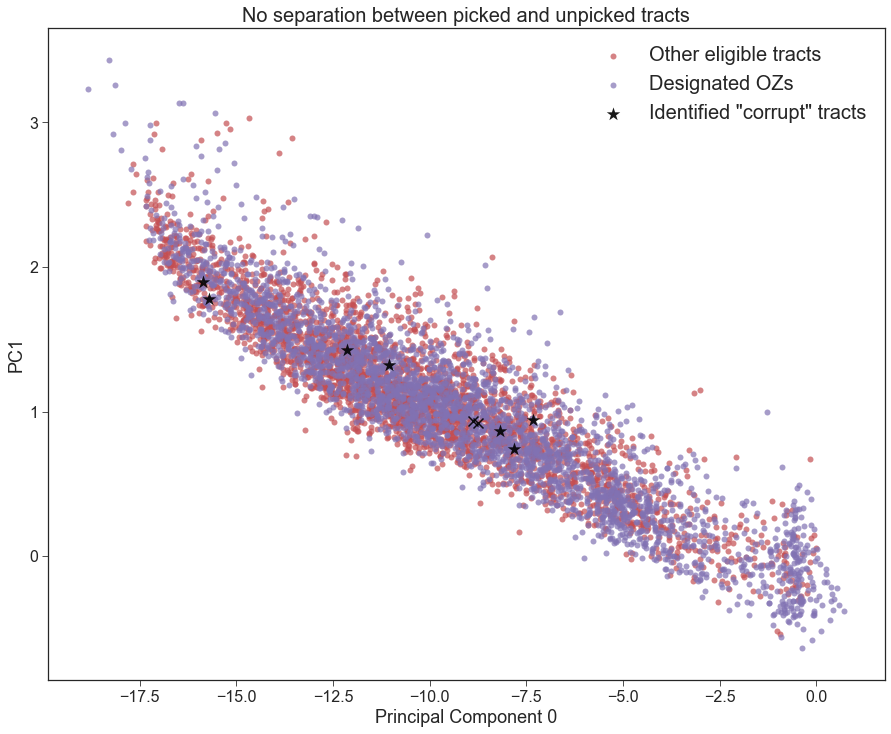

In [21]:
fig, ax = plt.subplots(figsize=(15, 12))
data_labels = ["Other eligible tracts", "Designated OZs"]
for i, p in enumerate(pca_objs):
    ## plot picked and not-picked
    pca_2comp_plot(ax, pca_all, data[i], n_points=3000, \
        scatter_kwargs={'color':palette[i+3],'alpha':0.7, 'label':data_labels[i]})

#plot corrupt tracts
pca_2comp_plot(ax, pca_all, suspect, show_centroid=False, \
        scatter_kwargs={'color':'k', 'marker':"*", 's':200,\
                        'alpha':0.9, 'label':'Identified \"corrupt\" tracts'})
  
ax.set_title("No separation between picked and unpicked tracts", fontsize=20)

plt.savefig("{}/pca_noseparation.png".format(images), dpi=120, transparent=True)

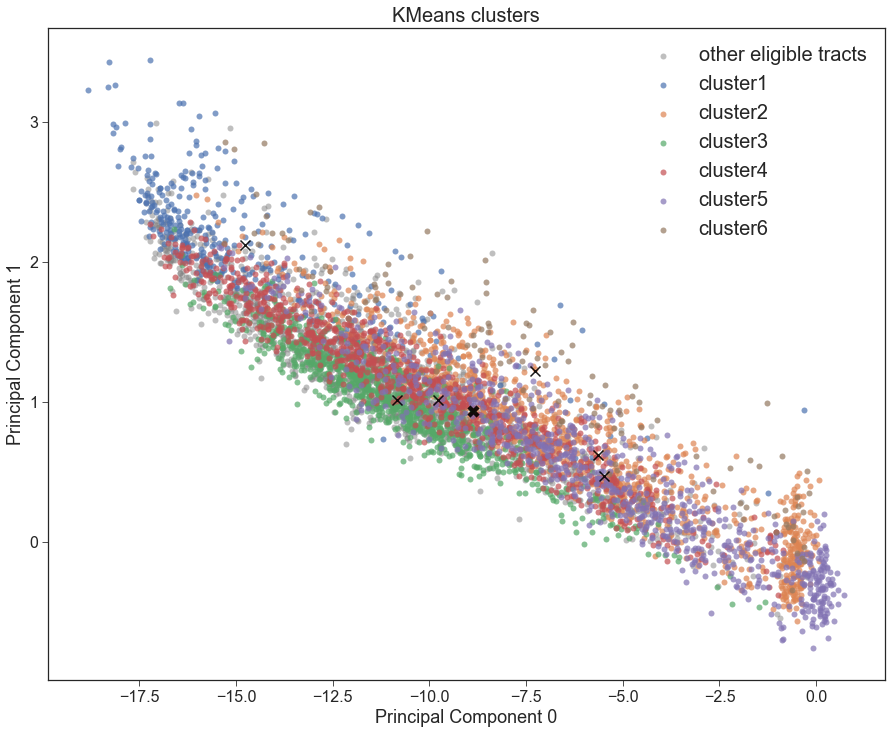

In [36]:
fig, ax = plt.subplots(figsize=(15, 12))
data_labels = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'other eligible tracts']
for i, p in enumerate(pca_objs):

    if i == 1: ## in other words, if we're working on oz data
        for j, mask in enumerate(cluster_masks):
            pca_2comp_plot(ax, pca_all, data[i][mask], n_points=1000, \
                scatter_kwargs={'color':palette[j],'alpha':0.7, 'label':data_labels[j]})
    else:
        pca_2comp_plot(ax, pca_all, data[i], n_points=1500,\
            scatter_kwargs={'color':'gray','alpha':0.5, 'label':data_labels[-1]},\
            centroid_kwargs={'marker':"X", 's':150})
  
ax.set_title("KMeans clusters", fontsize=20)

plt.savefig("{}/pca_clusters.png".format(images), dpi=120, transparent=True)

In [58]:
## loading ranks
def _loadings(pca_object):
    components = pca_object.components_
    for c in components:
        sorted_i_desc = np.argsort(c)
        print(feature_labels[sorted_i_desc])
_loadings(pca_all)

TypeError: only integer scalar arrays can be converted to a scalar index

In [90]:
def percent_differences(data1, data2):
    array = []
    for feature in range(len(data1[0, :])):
        a, b = data1[:, feature], data2[:, feature]
        percent_diff = (np.mean(a) - np.mean(b)) / np.mean(b)
        _, prob = wstats.ztest(a, b)
        array.append([percent_diff, prob])
    return np.array(array)

In [137]:
pp = percent_differences(X_ozs.values, X_alle.values)
changes = pp[:,0]
sig_zproba = pp[:, 1] < 0.05
color_seq = np.array([palette[7] for c in range(len(changes))])
# red = index 3, green = 2
gainloss = np.where(changes >= 0, palette[2], palette[3])
color_seq[sig_zproba] = gainloss[sig_zproba]
color_seq

array(['#8c8c8c', '#c44e52', '#55a868', '#8c8c8c', '#c44e52', '#8c8c8c',
       '#8c8c8c', '#c44e52', '#8c8c8c', '#8c8c8c', '#8c8c8c', '#8c8c8c',
       '#8c8c8c', '#8c8c8c'], dtype='<U7')

Text(0.5, 1.0, 'Feature means of OZs relative to all eligible tracts')

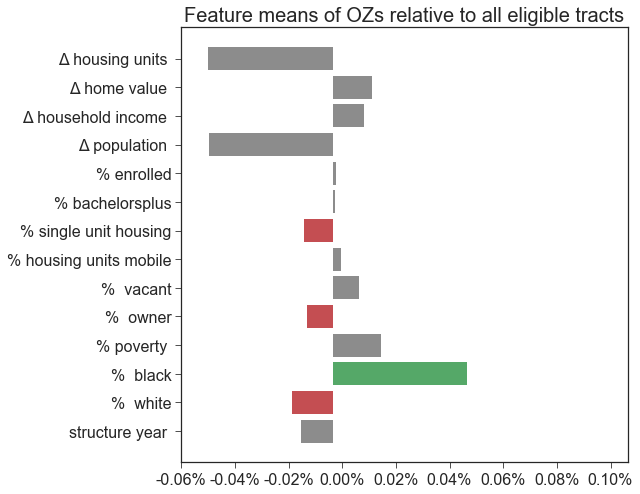

In [170]:
def percentage_plot(ax, features, centroid, kwargs={}):
    '''Plot percent change of each feature on the cluster. Set ax title outside.
    Params:
        ax: Matplotlib ax object to plot on
        features: array of strings (n,)
        centroid: array of weightings (n,)
    '''
    y = np.arange(len(centroid))
    ax.barh(y, centroid, tick_label=features, **kwargs)
    ax.set_yticklabels(features, fontsize=16)
    xmin, xmax = np.min(centroid) - 0.01, np.max(centroid) + 0.06
    xtks = np.arange(xmin, xmax, .02)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(xtks)
    ax.set_xticklabels(["{:.2f}%".format(i) for i in xtks])

f,ax =plt.subplots(figsize=(8,8))
percentage_plot(ax, feature_labels, pp[:,0], kwargs={'color':color_seq})
ax.set_title("Feature means of OZs relative to all eligible tracts", fontsize=20)